# Pre-processing, QC, and filtering of all samples

Date: 03 June 2021

Notes: pre-processing for analysis WITHOUT cp190 WITH kb-pythonmultimapping

re-run on 30 June 2021 to save figures 

In [32]:
# Import packages and general setup

import anndata
from anndata import AnnData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

from collections import OrderedDict
from sklearn.preprocessing import normalize

# This function takes an array, and returns a numpy array that makes sure the new shape 
# is compatible with the old shape using .reshape(-1)

def nd(arr):
    return np.asarray(arr).reshape(-1)

import warnings
warnings.filterwarnings('ignore')

# matplotlib settings

fsize=20
plt.rcParams.update({'font.size': fsize, 'axes.grid':False})
%config InlineBackend.figure_format = 'retina'

# scanpy settings 

sc.set_figure_params(dpi_save = 400, fontsize = 20)

## Load AnnData

In [2]:
# load t2g.txt (transcripts to genes)

t2g = pd.read_csv("../../bin/t2g.txt", header=None, usecols = [0,1,2], names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]


# load unfiltered matrices 

adata1 = anndata.read_h5ad("/Volumes/Mac-External/insulator/control-processed-mm/counts_unfiltered/adata.h5ad")
adata1.var["gene_id"] = adata1.var.index.values

adata2 = anndata.read_h5ad("/Volumes/Mac-External/insulator/ctcf-processed-mm/counts_unfiltered/adata.h5ad")
adata2.var["gene_id"] = adata2.var.index.values


# the processed data are IDed according to their gene_id, this just maps it to gene_name making it easier to do 
# analysis with specific genes later

adata1.var["gene_name"] = adata1.var.gene_id.map(t2g["gene_name"])
adata1.var.index = adata1.var["gene_name"]

adata2.var["gene_name"] = adata2.var.gene_id.map(t2g["gene_name"])
adata2.var.index = adata2.var["gene_name"]

## Quality control 

In [3]:
anndatas = [adata1, adata2]

for a in anndatas[0:len(anndatas)]: 
    # Calculate cell and gene counts

    a.obs["cell_counts"] = a.X.sum(axis=1)
    a.var["gene_counts"] = nd(a.X.sum(axis=0))

    # Calculate number of genes

    a.obs["n_genes"] = nd((a.X>0).sum(axis=1))
    a.var["n_cells"] = nd((a.X>0).sum(axis=0))

    # Calculate percent mitochondrial expression

    mito_genes = a.var["gene_name"].str.startswith('mt:')
    mito_genes = mito_genes.astype(bool)
    a.obs["percent_mito"] = a[:, mito_genes].X.sum(axis=1)/a.X.sum(axis=1)*100

In [4]:
# Detect nan gene names
nangene1 = adata1.var["gene_name"].isna()
nangene2 = adata2.var["gene_name"].isna()

# Remove nan gene names
adata1 = adata1[:, ~nangene1]
adata2 = adata2[:, ~nangene2]

In [5]:
adata1

View of AnnData object with n_obs × n_vars = 204948 × 17868
    obs: 'cell_counts', 'n_genes', 'percent_mito'
    var: 'gene_name', 'gene_id', 'gene_counts', 'n_cells'

In [6]:
adata2

View of AnnData object with n_obs × n_vars = 295443 × 17868
    obs: 'cell_counts', 'n_genes', 'percent_mito'
    var: 'gene_name', 'gene_id', 'gene_counts', 'n_cells'

#### Percent Mitochondrial Expression

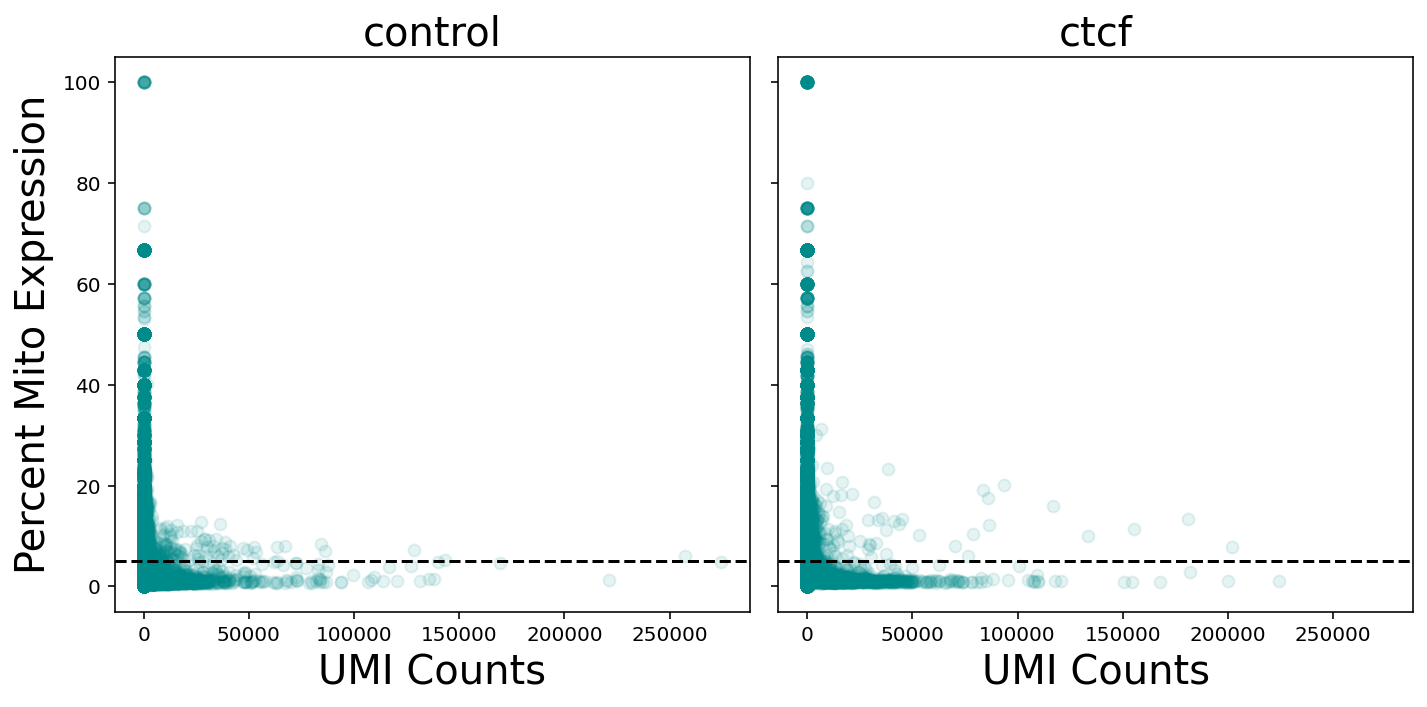

In [7]:
mito_criteria = 5

fig, axs = plt.subplots(1, 2, figsize=(5*2,5), sharex = True, sharey = True)

x0 = nd(adata1.obs["cell_counts"])
y0 = nd(adata1.obs["percent_mito"])

x1 = nd(adata2.obs["cell_counts"])
y1 = nd(adata2.obs["percent_mito"])

axs[0].scatter(x0, y0, color = "darkcyan", alpha = 0.1)
axs[0].set_ylabel("Percent Mito Expression", fontsize = 20)
axs[0].set_title("control", fontsize = 20)

axs[1].scatter(x1, y1, color = 'darkcyan', alpha = 0.1)
axs[1].set_title("ctcf", fontsize = 20)

for ax in axs: 
    ax.axhline(y=mito_criteria, linestyle = "--", color = "k")
    ax.set_xlabel('UMI Counts', fontsize = 20)
    ax.grid(False)    
    
plt.tight_layout()
#plt.savefig('1_percentmito.png', dpi = 400)
plt.show()

#### Knee Plot

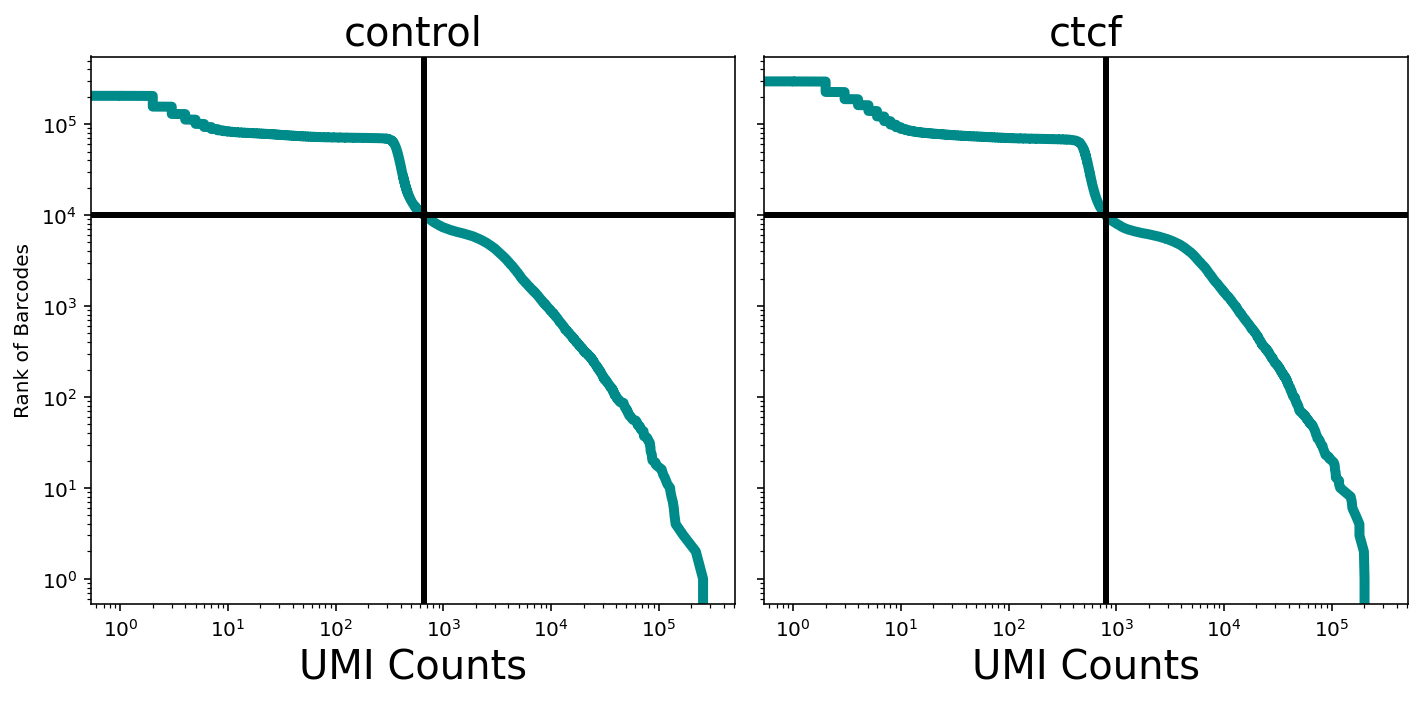

In [8]:
expected_num_cells0 = 10000#@param {type:"integer"}
expected_num_cells1 = 10000#@param {type:"integer"}

fig, axs = plt.subplots(1, 2, figsize=(5*2, 5), sharex = True, sharey = True)

knee0 = np.sort(nd(adata1.X.sum(axis=1)))[::-1]
x0 = knee0
y0 = range(len(knee0))

knee1 = np.sort(nd(adata2.X.sum(axis=1)))[::-1]
x1 = knee1
y1 = range(len(knee1))


axs[0].loglog(x0, y0, linewidth=5, color="darkcyan")
axs[0].axvline(x=knee0[expected_num_cells0], linewidth=3, color="k")
axs[0].axhline(y=expected_num_cells0, linewidth=3, color="k")
axs[0].set_title("control", fontsize = 20)

axs[0].set_ylabel("Rank of Barcodes")

axs[1].loglog(x1, y1, linewidth=5, color="darkcyan")
axs[1].axvline(x=knee1[expected_num_cells1], linewidth=3, color="k")
axs[1].axhline(y=expected_num_cells1, linewidth=3, color="k")
axs[1].set_title("ctcf", fontsize = 20)
    
       
for ax in axs:      
     ax.set_xlabel("UMI Counts", fontsize = 20)
     ax.grid(False)    
    
plt.tight_layout()    
#plt.savefig('1_knee.png', dpi = 400)
plt.show()

#### Library Saturation

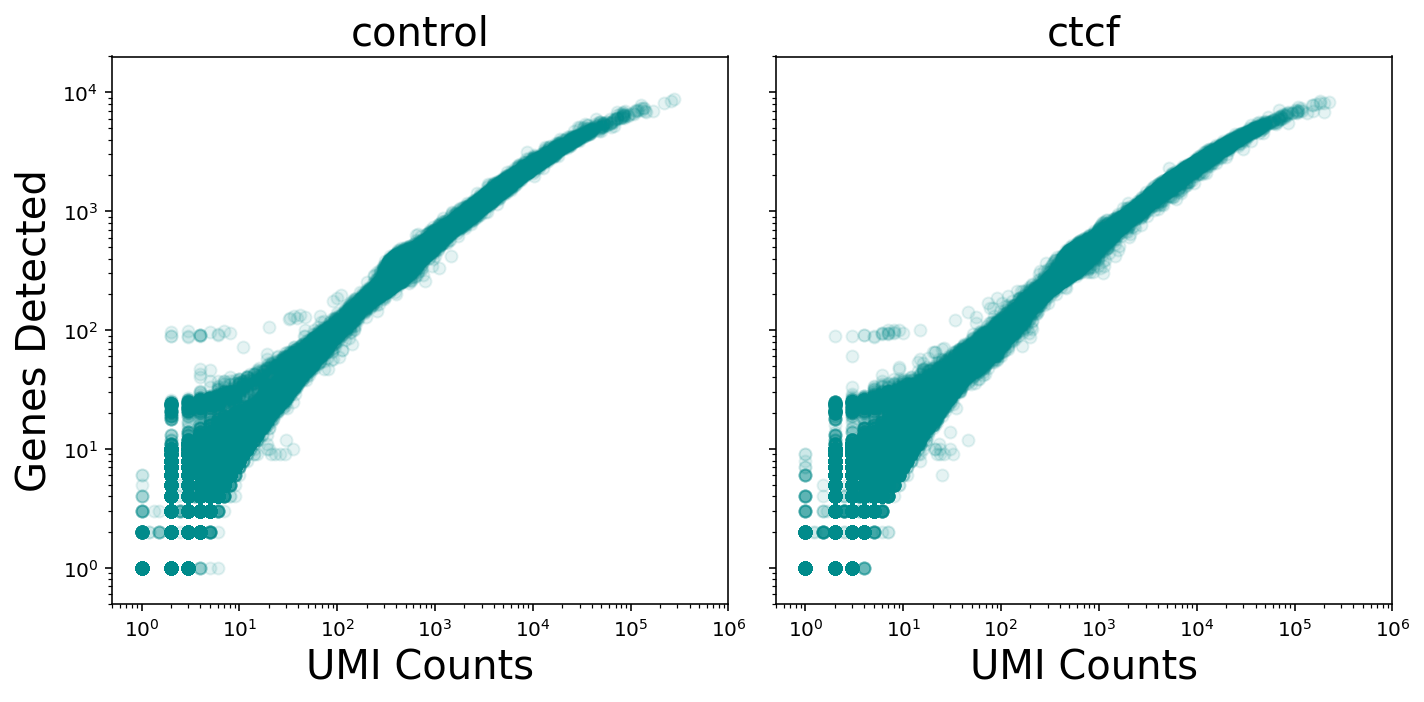

In [9]:
# Create a plot showing genes detected as a function of UMI counts.
fig, axs = plt.subplots(1, 2, figsize=(5*2, 5), sharex = True, sharey = True)

axs[0].scatter(np.asarray(adata1.X.sum(axis=1))[:,0], np.asarray(np.sum(adata1.X>0, axis=1))[:,0], color="darkcyan", alpha=0.1)
axs[0].set_ylabel("Genes Detected", fontsize = 20)
axs[0].set_title("control", fontsize = 20)

axs[1].scatter(np.asarray(adata2.X.sum(axis=1))[:,0], np.asarray(np.sum(adata2.X>0, axis=1))[:,0], color="darkcyan", alpha=0.1)
axs[1].set_title("ctcf", fontsize = 20)


for ax in axs: 
    ax.set_xscale('log')
    ax.set_yscale('log', nonposy='clip')
    ax.set_xlabel("UMI Counts", fontsize = 20)
    ax.set_xlim((0.5, 1000000))
    ax.set_ylim((0.5,20000))
    ax.grid(False)

    
plt.tight_layout()
#plt.savefig('1_libsat.png', dpi = 400)
plt.show()

## Filter



#### adata1

In [10]:
adata1

View of AnnData object with n_obs × n_vars = 204948 × 17868
    obs: 'cell_counts', 'n_genes', 'percent_mito'
    var: 'gene_name', 'gene_id', 'gene_counts', 'n_cells'

In [11]:
# Filter empty droplets based on knee plot threshold 
sc.pp.filter_cells(adata1, min_counts=knee0[expected_num_cells0])

# Remove nuclei with fewer than x genes expressed 
sc.pp.filter_cells(adata1, min_genes=200)

# Filter on mitochondrial percent 
adata1 = adata1[adata1.obs.percent_mito < 5]

# Remove nuclei with high UMI counts
adata1 = adata1[adata1.obs.cell_counts < 50000]

# Remove genes in too few cells 
sc.pp.filter_genes(adata1, min_cells=3)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.var` of view, copying.


In [12]:
adata1

AnnData object with n_obs × n_vars = 8436 × 12616
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_name', 'gene_id', 'gene_counts', 'n_cells'

In [13]:
# setup

def vplot(y, ax):
    parts = ax.violinplot(
        y, showmeans=False, showmedians=False,
        showextrema=False)

    mean = y.mean()
    ax.scatter(1, mean, zorder=10, color="white")
    
    x = np.random.normal(1, 0.04, size=len(y))
    ax.scatter(x, y, color="k", s=1)
    
    for pc in parts['bodies']:
        pc.set_facecolor('thistle')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    ax.set_xticks([1])
    ax.set_xticklabels([""])
    ax.grid(False)
    return ax

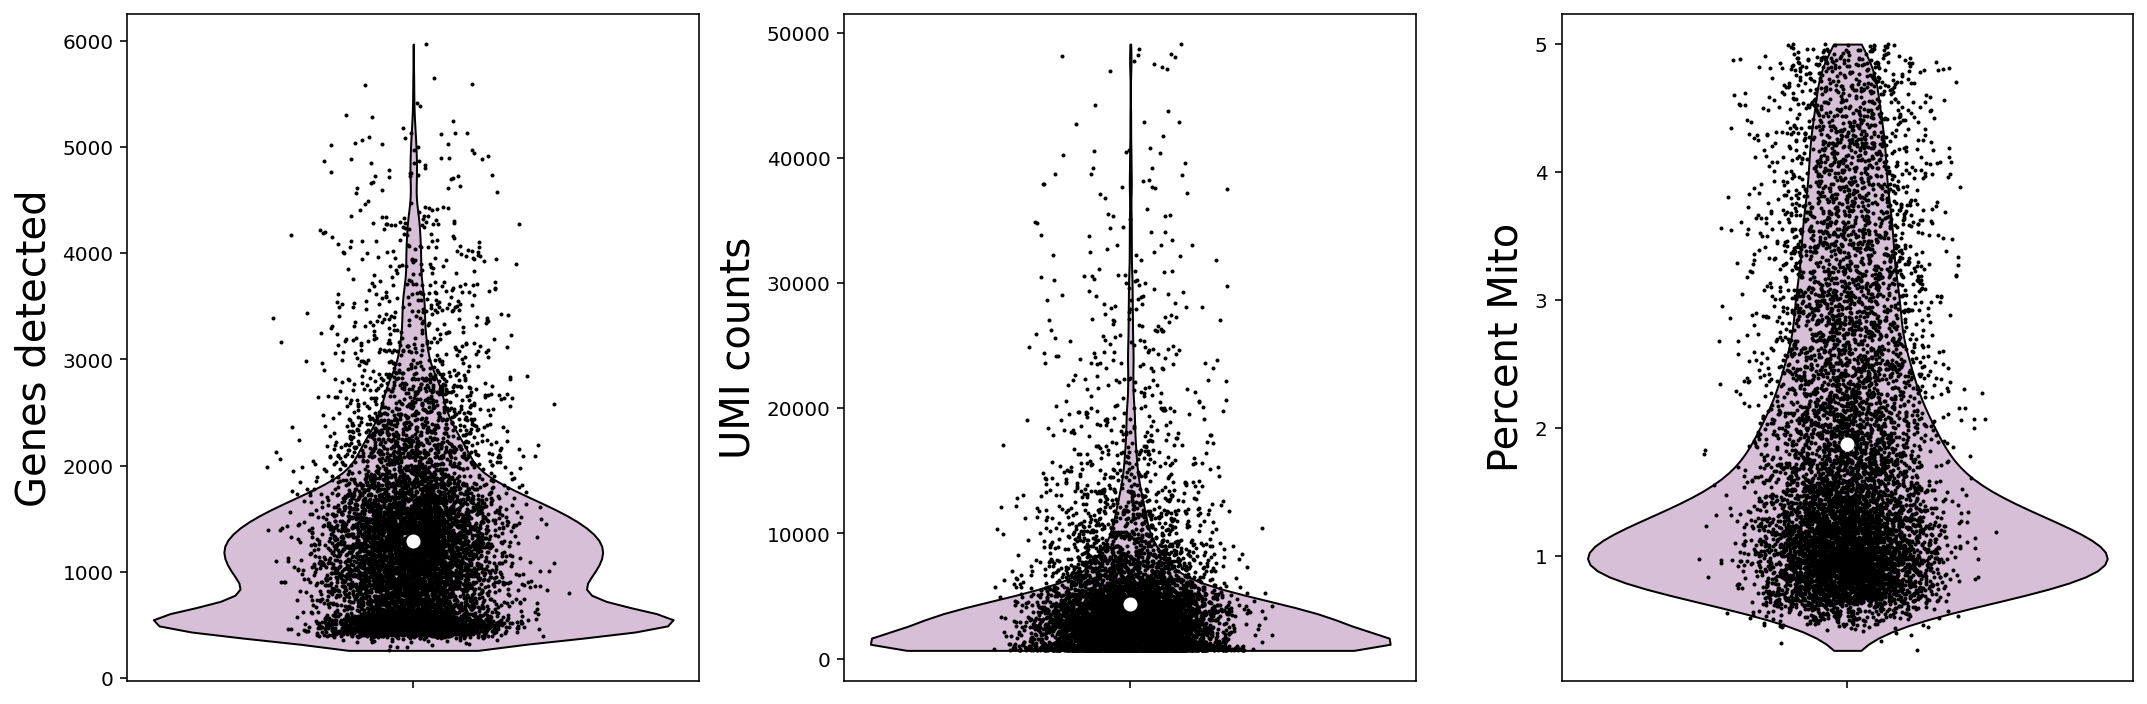

In [14]:
# Visualize count distributions

fig, ax = plt.subplots(figsize=(5*3,5), ncols=3)

x1 = adata1.obs["n_genes"]
x2 = nd(adata1.X.sum(axis=1))
x3 = adata1.obs["percent_mito"]

ax[0].set_ylabel("Genes detected", fontsize = 20)
ax[1].set_ylabel("UMI counts", fontsize = 20)
ax[2].set_ylabel("Percent Mito", fontsize = 20)


vplot(x1, ax[0])
vplot(x2, ax[1])
vplot(x3, ax[2])

for ax in axs: 
    ax.set_xlim((0.5, 1000000))
    ax.set_ylim((0.5,20000))


plt.tight_layout()
#plt.savefig('1_QC_control.png', dpi = 400)
plt.show()

#### adata2

In [15]:
adata2

View of AnnData object with n_obs × n_vars = 295443 × 17868
    obs: 'cell_counts', 'n_genes', 'percent_mito'
    var: 'gene_name', 'gene_id', 'gene_counts', 'n_cells'

In [16]:
# Filter empty droplets based on knee plot threshold 
sc.pp.filter_cells(adata2, min_counts=knee1[expected_num_cells1])

# Remove nuclei with fewer than x genes expressed 
sc.pp.filter_cells(adata2, min_genes=200)

# Filter on mitochondrial percent 
adata2 = adata2[adata2.obs.percent_mito < 5]

# Remove nuclei with high UMI counts
adata2 = adata2[adata2.obs.cell_counts < 50000]

# Remove genes in too few nuclei 
sc.pp.filter_genes(adata2, min_cells=3)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.var` of view, copying.


In [17]:
adata2

AnnData object with n_obs × n_vars = 6354 × 13206
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_name', 'gene_id', 'gene_counts', 'n_cells'

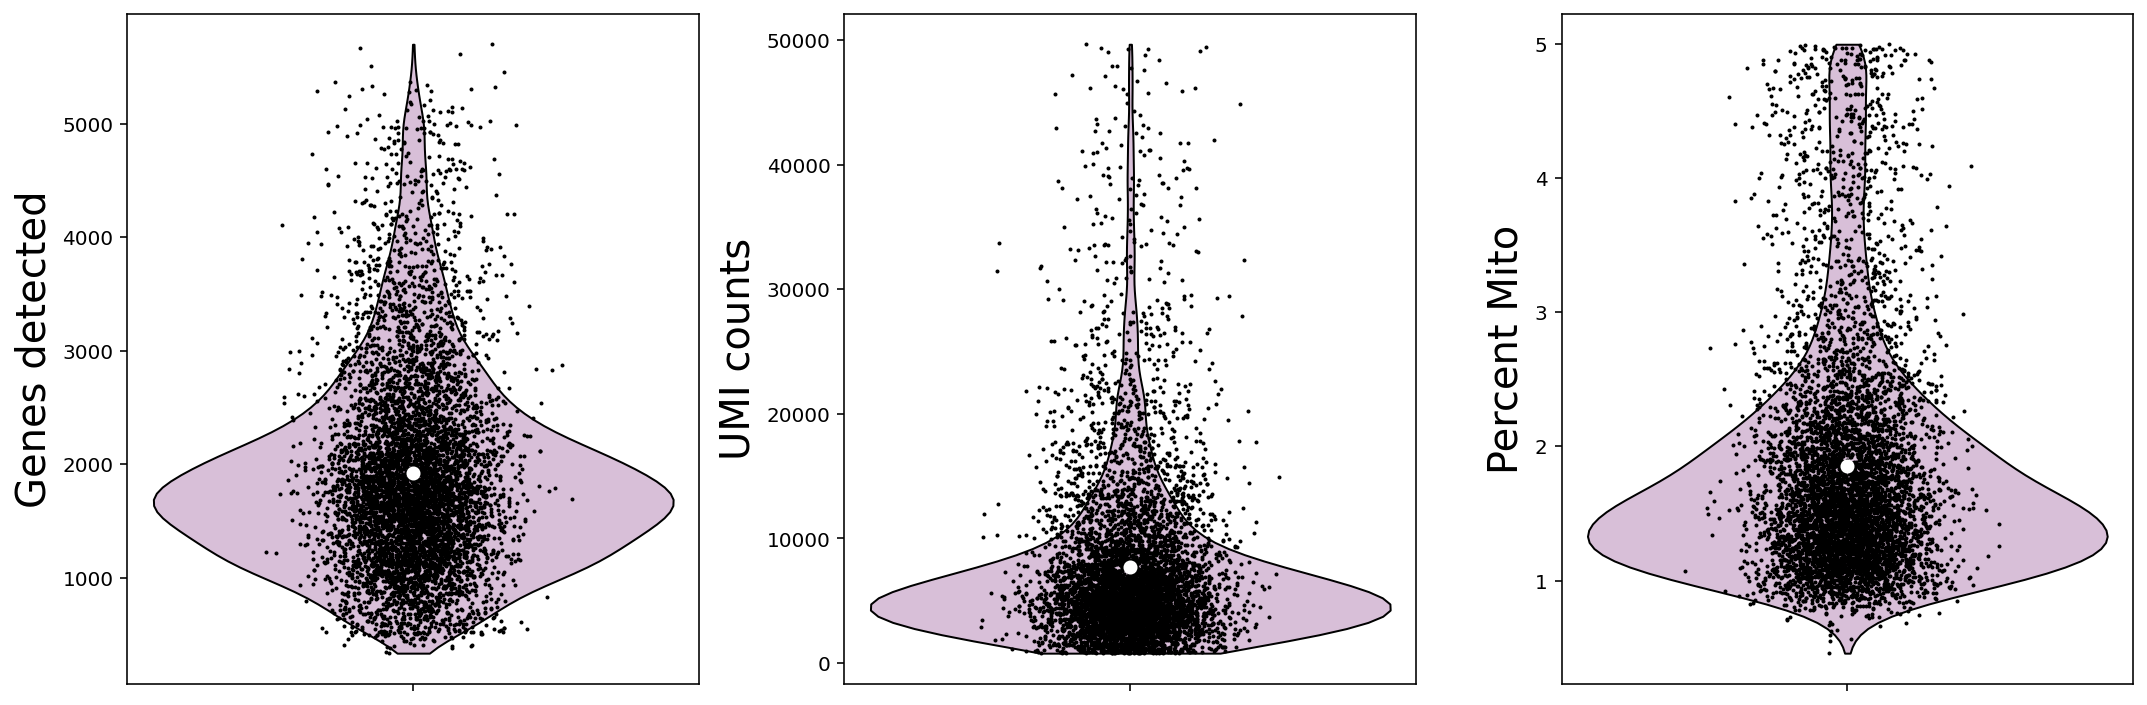

In [18]:
fig, ax = plt.subplots(figsize=(5*3,5), ncols=3)

x1 = adata2.obs["n_genes"]
x2 = nd(adata2.X.sum(axis=1))
x3 = adata2.obs["percent_mito"]

ax[0].set_ylabel("Genes detected", fontsize = 20)
ax[1].set_ylabel("UMI counts", fontsize = 20)
ax[2].set_ylabel("Percent Mito", fontsize = 20)


vplot(x1, ax[0])
vplot(x2, ax[1])
vplot(x3, ax[2])


plt.tight_layout()
#plt.savefig('1_QC_ctcf', dpi = 400)
plt.show()

## Combine and save adata


In [36]:
adata = adata1.concatenate(adata2)

In [37]:
# adata.write did not like the index and a column having the same name.... 

adata.var.rename(columns={"gene_name" : "gene"}, inplace = True)

In [38]:
adata

AnnData object with n_obs × n_vars = 14790 × 12357
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1'

In [123]:
#adata.write('../../results/insulator_withoutcp190_mitounder5_multimap_060321.h5ad')

## Setup adata for clustering

In [40]:
# create a layer containing the raw data 
adata.layers['raw'] = adata.X

In [41]:
# normalize and scale 
scale_num = 10000
adata.layers["norm"] = normalize(adata.X, norm="l1", axis=1)*scale_num

# log1p 
adata.layers["log1p"] = np.log1p(adata.layers["norm"])
adata.uns = OrderedDict([("log1p", {"base":None})])
adata.X = adata.layers["log1p"]

## Gene x gene counts

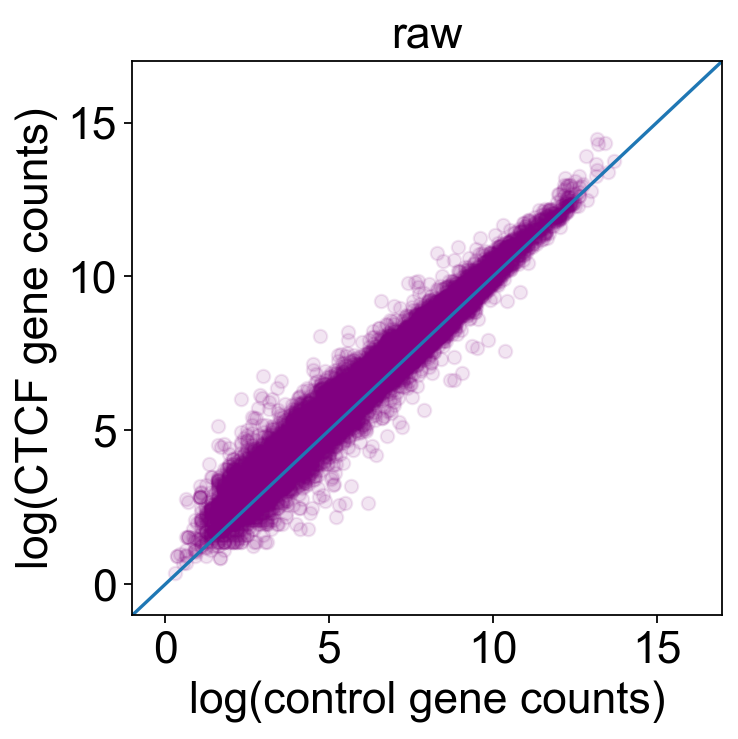

In [42]:
# raw gene x gene counts 
fig, ax = plt.subplots(figsize=(5,5))

x = np.log1p(adata.var['gene_counts-0'])
y = np.log1p(adata.var['gene_counts-1'])

ax.scatter(x, y, color = 'purple', alpha = 0.1) 

ax.set_xlabel("log(control gene counts)")
ax.set_ylabel("log(CTCF gene counts)")
ax.plot([0,1],[0,1], transform=ax.transAxes)

ax.set_xlim(-1,17)
ax.set_ylim(-1,17)
ax.set_title('raw')
ax.grid(False)

plt.tight_layout()
plt.savefig('1_genexgeneraw.png', dpi = 400)
plt.show()


In [45]:
# subset control adata
adata1_ = adata[adata.obs['batch'] == '0',:]

# set X to normalized layer
adata1_.X = adata1_.layers['norm']

# sum the counts of normalized genes across all nuclei 
adata1_.var['norm_counts'] = nd(adata1_.X.sum(axis=0))

In [48]:
# subset ctcf adata
adata2_ = adata[adata.obs['batch'] == '1',:]

# set X to normalized layer
adata2_.X = adata2_.layers['norm']

# sum the couns of normalized genes across all nuclei
adata2_.var['norm_counts'] = nd(adata2_.X.sum(axis=0))

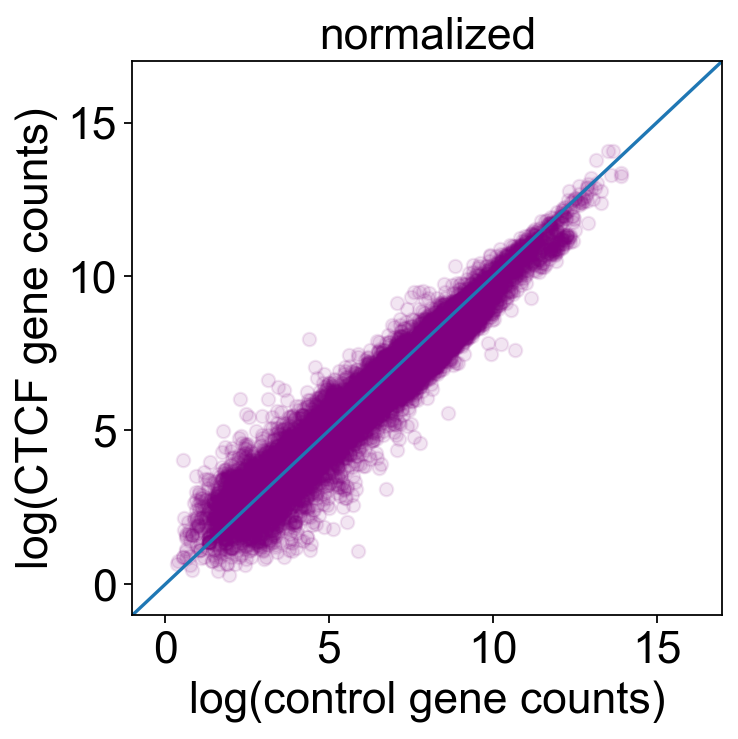

In [52]:
# normalized gene x gene counts
fig, ax = plt.subplots(figsize=(5,5))

x = np.log1p(adata1_.var['norm_counts'])
y = np.log1p(adata2_.var['norm_counts'])
ax.scatter(x, y, color = 'purple', alpha = 0.1) 

ax.set_xlabel("log(control gene counts)")
ax.set_ylabel("log(CTCF gene counts)")
ax.plot([0,1],[0,1], transform=ax.transAxes)

ax.set_xlim(-1,17)
ax.set_ylim(-1,17)

ax.set_title("normalized")
ax.grid(False)

plt.tight_layout()
plt.savefig('1_genexgenenorm.png', dpi = 400)
plt.show()


## Clustering before batch correction

In [43]:
# set X to log1p and scale 
adata.X = adata.layers['log1p']
sc.pp.scale(adata, max_value=10)

In [44]:
# parameters used to find highly variable genes 
n_top_genes = 6000
n_bins = 20
flavor="seurat"

In [45]:
# Friendly reminder - this requires log data
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)

In [49]:
# Cluster the nuclei
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True, n_comps=10)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10, knn=True)
sc.tl.leiden(adata, resolution = 0.5)

In [50]:
# embed the neighborhood graph using UMAP 
sc.tl.umap(adata)

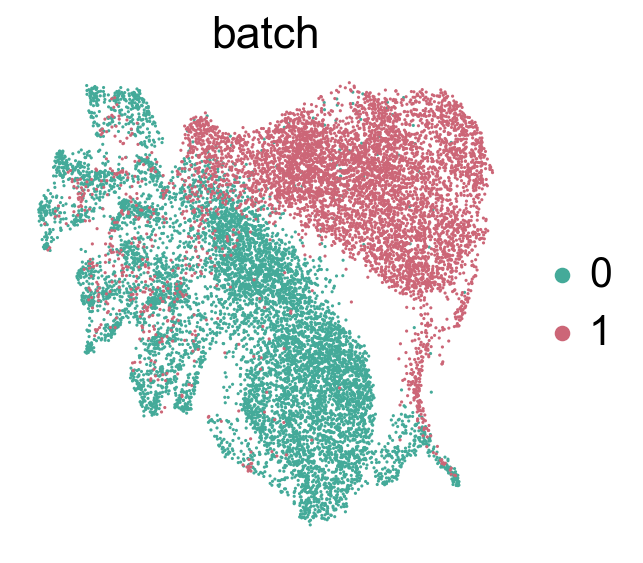

In [51]:
# plot UMAP by batch 
sc.pl.umap(adata, 
           color=['batch'], 
           use_raw=False, 
           frameon=False, 
           palette = ['#44AA99', '#CC6677'])
           #save = '1_clusterb4batchcorrect.png')
